# Pre-2010 A&E data

Main data page: https://webarchive.nationalarchives.gov.uk/20130104202128/http://www.dh.gov.uk/en/Publicationsandstatistics/Statistics/Performancedataandstatistics/AccidentandEmergency/DH_079085

In [1]:
import numpy as np
import importlib
import requests, bs4, os
import pandas as pd
import numpy as np
from time import strptime
import matplotlib.patheffects as pe

def getOnlineXLS(url, file = 'tempfile.xls'):
    resp = requests.get(pref + url)
    # Store the data in a temporary file
    tempfile = open(file, 'wb')
    tempfile.write(resp.content)
    tempfile.close()
    return 0

def get_xls_files(pages, verbose = 0):
    '''
    Collects the names of the relevent xls files from the given list of webpages
    '''
    xls_file_names = []

    for name in pages:
        #print("Looking at page: ", name, '\n')
        res = requests.get(name)
        soup = bs4.BeautifulSoup(res.content, features="lxml")
        linkElems = soup.select("a")
        for elem in linkElems:
            if '.xls' in elem.get('href'):
                xls_file_names.append(elem.get('href'))
                
    if verbose >= 10:
        print("Total of {} xls files found.".format(len(xls_file_names)))
        
    return xls_file_names

pref = "https://webarchive.nationalarchives.gov.uk/"
def get_all_names(firstSheet, file = 'tempfile.xls', verbose = 0):
    getOnlineXLS(firstSheet)
    sheetName = findFirstVisible(file)
    sheet = pd.read_excel(file, sheet_name=sheetName, skiprows=14, usecols="D")
    
    currentNames = sheet["Name"].values

    allNames2 = []
    for name in currentNames:
        if type(name) == str:
            allNames2.append(name)
    
    return np.asarray(allNames2)

def findFirstVisible(file):
    xls = pd.ExcelFile(file)
    sheets = xls.book.sheets()
    names = np.array([sheet.name for sheet in sheets])
    visibilities = np.array([sheet.visibility for sheet in sheets])
    return names[visibilities == 0] [0]

def getRowSkip(file = 'tempfile.xls'):
    sheetName = findFirstVisible(file)
    try:
        sheet = pd.read_excel(file, sheet_name=sheetName, skiprows=0, usecols="E")
        skip = np.where(sheet.values==["Name"])[0][0]
        cols = "E,F,G"
    except:
        sheet = pd.read_excel(file, sheet_name=sheetName, skiprows=0, usecols="D")
        skip = np.where(sheet.values==["Name"])[0][0]
        cols = "D,E,F"
    return skip, cols

def getSheetData(allNames, skip, cols, file = 'tempfile.xls'):
    sheetName = findFirstVisible(file)
    sheet = pd.read_excel(file, sheet_name=sheetName, skiprows=skip, usecols=cols)
    
    SheetVals = sheet.values
    
    names = SheetVals[1:,0]
    attendence = SheetVals[1:,1]
    waiting = SheetVals[1:,2]
    
    return names, attendence, waiting
    
    
def getAnEData_pre2010(dataSets, allNames):
    dates = np.zeros(len(dataSets))
    waiting = np.zeros((len(dataSets), len(allNames)), dtype = object)
    attendence = np.zeros((len(dataSets), len(allNames)), dtype = object)
    
    missing = []
    for i, dataSet in enumerate(dataSets):
        getOnlineXLS(dataSet) 
        skip, cols = getRowSkip('tempfile.xls')
        newNames, newAtt, newWait = getSheetData(allNames, skip, cols)
        #print(newNames.shape, newAtt.shape, newWait.shape)
        for j, name in enumerate(allNames):
            if name in newNames:
                index = np.where(newNames == name)[0][0]
                attendence[i,j] = newAtt[index]
                waiting[i,j] = newWait[index]
            elif name not in missing:
                missing.append(name)
                
        print("{}/{}\t\t".format(i, len(dataSets)), end = "\r")
        
    return waiting, attendence, missing

def plotwaiting(index,ax):
    mask = (waiting[:,index]!="-")*(attendence[:,index]!="-")
    waitingNum = waiting[:,index][mask]
    years = np.linspace(2011+3/8, 2003+1/8, 35)
    ax.plot(years,waitingNum*100, "-", lw = 3)

In [2]:
url = "https://webarchive.nationalarchives.gov.uk/20130105020054/http://www.dh.gov.uk/en/Publicationsandstatistics/Statistics/Performancedataandstatistics/AccidentandEmergency/DH_087978"
xls_file_names = get_xls_files([url], verbose = 10)

Total of 0 xls files found.


In [3]:
allNames = get_all_names(xls_file_names[0], verbose = 0)

IndexError: list index out of range

In [ ]:
waiting, attendence, missing = getAnEData_pre2010(xls_file_names, allNames)

In [ ]:
NewNames, Newperiods, NewWaiting = np.load("type1_post2010.npy", allow_pickle = True)  

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

dates = np.asarray(Newperiods)
bins = np.arange(2011.25, 2021.25, 0.25)
# Convert date into quarterly 
sampled_dates = []
sampled_values = []
for i in range(len(bins)-1):
    sampled_dates.append(np.mean(dates[(dates > bins[i])*(dates <= bins[i+1])]))
    sampled_values.append(np.mean(NewWaiting[0][(dates > bins[i])*(dates <= bins[i+1])]))
    
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)
    
# 2005
e1 = 2005 + 4/12 + 5/365
ax.plot([e1, e1], [0,64], "-", color = "gray")
ax.plot([e1, e1], [77,100], "-", color = "gray")
ax.fill_between([2000, e1], [0,0], [100, 100], color = "r", alpha = 0.3, lw=0)

# 2010
e2 = 2010 + 4/12 + 6/365
ax.plot([e2, e2], [0,100], "-", color = "gray")

ax.fill_between([e1, e2], [0,0], [100, 100], color = "r", alpha = 0.3, lw=0)


# 2015
e3 = 2015 + 4/12 + 7/365
ax.plot([e3, e3], [0,100], "-", color = "gray")


for i in range(0,10):
    x = np.linspace(e2, e3, 100)
    y1 = 50 + i*5 + (x-e1)
    
    if i % 2:
        ax.fill_between(x, y1, y1+5, color = "b", alpha = 0.3,lw=0)
    else:
        ax.fill_between(x, y1, y1+5, color = "y", alpha = 0.5,lw=0)

# 2017
e4 = 2017 + 5/12 + 8/365
ax.plot([e4, e4], [0,85], "-", color = "gray")
ax.plot([e4, e4], [99.5,100], "-", color = "gray")
ax.fill_between([e3, e4], [0,0], [100, 100], color = "b", alpha = 0.3,lw=0)

# 2019
e5 = 2019 + 11/12 + 12/365
ax.plot([e5, e5], [0,62.8], "-", color = "gray")
ax.plot([e5, e5], [76.5,100], "-", color = "gray")
ax.fill_between([e4, e5], [0,0], [100, 100], color = "b", alpha = 0.3,lw=0)

ax.fill_between([e5, 2024], [0,0], [100, 100], color = "b", alpha = 0.3,lw=0)


sampled_values = np.asarray(sampled_values)
sampled_dates = np.asarray(sampled_dates)
years = np.linspace(2011+3/8, 2003+1/8, 35)

all_waiting = np.concatenate((waiting[:,0][::-1], sampled_values))
all_dates = np.concatenate((years[::-1], sampled_dates))

from scipy.interpolate import interp1d

waiting_interp = interp1d(all_dates, all_waiting)
x = np.linspace(min(all_dates), max(all_dates), 100000)
y = waiting_interp(x)*100

path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal(), 
              pe.SimpleLineShadow(alpha = 0.4, offset=(2,-2))]

mask1 = y >= 95
mask2 = y <= 95

ax.plot(x[mask2 * (x<2004.9)], y[mask2 * (x<2004.9)], "-", lw=3, color = "#e60000",path_effects = path_effects)
ax.plot(x[(x>2010.5)], y[(x>2010.5)], "-", lw=3, color = "#e60000", path_effects = path_effects)
ax.plot(x[mask1], y[mask1], "-", lw=3, color = "#33cc33", path_effects = path_effects)
ax.plot([2002, 2021], [95, 95], "-", lw = 2, color = "k", path_effects = path_effects)
ax.plot([2002, 2021], [95, 95], "--", lw = 2, color = "yellow", path_effects = path_effects)
ax.annotate("(Old) 95% Target", (2014, 96), size = 18)
ax.axis([2002.5, 2021, 60, 100])
ax.set_xticks(np.arange(2005, 2025, 5))

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def plotFace(file, x0, y0, ax):
    img = mpimg.imread(file)
    img = rgb2gray(img)
    ax.imshow(img, extent = (x0, x0+4, y0, y0+15),aspect='auto', cmap = "gray")
    
plotFace("../../Faces/blair.png", 2003, 63, ax)
plotFace("../../Faces/brown.png", 2006, 78, ax)
plotFace("../../Faces/cameron.png", 2011, 80, ax)
plotFace("../../Faces/clegg.jpg", 2011, 62, ax)
plotFace("../../Faces/may.jpg", 2015.5, 85, ax)
plotFace("../../Faces/johnson.png", 2017.3, 62, ax)
ax.set_title("% of A&E patients who receive\ncare within 4 hours*")
plt.savefig("type1Overtime.png",dpi = 100)

In [ ]:
640*16/9

In [4]:
NewNames, Newperiods, NewWaiting = np.load("type1_post2010.npy", allow_pickle = True)  

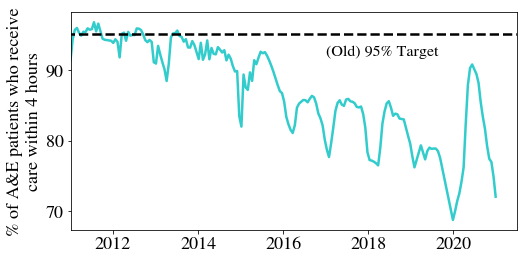

In [8]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=18)

waiting_interp = interp1d(Newperiods, NewWaiting[NewNames == "England"][0])
years = np.linspace(2011, 2021, 200)

fig = plt.figure(figsize = (8,4))
plt.plot(years, waiting_interp(years)*100, lw = 2.5, color = "#33cccc")
plt.ylabel("% of A&E patients who receive\ncare within 4 hours")
plt.xlim(2011, 2021.5)
plt.annotate("(Old) 95% Target", (2017, 92), size = 16)
plt.plot([2002, 2021.5], [95, 95], "--", lw = 2.5, color = "k")
plt.savefig("AnE_England.pdf", bbox_inches = "tight")